## Preparation

In [1]:
import tqdm
import os
import cv2
import imghdr
import image_to_numpy
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
import itertools

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomBrightness, Rescaling, Resizing
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.metrics import F1Score, Precision, Recall, CategoricalAccuracy

import sklearn
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
data_dir = 'D:\DATASETS\For-Thesis\Labels'

In [3]:
def sample_count(data_dir):
    for dir in os.listdir(data_dir):
        print("{}: {}".format(dir, len(os.listdir(os.path.join(data_dir,dir)))))

In [4]:
sample_count(data_dir)

Building: 600
Plant: 600
Road: 600
Vehicle: 600


## Prepare Dataset

In [5]:
labels = ['Building', 'Plant', 'Road', 'Vehicle']
X_train = []
y_train = []
y_label_idx = []
image_size = 256
for i in labels:
    folderPath = os.path.join('D:\DATASETS\For-Thesis\Labels', i)
    for j in os.listdir(folderPath):
        img = image_to_numpy.load_image_file(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_label_idx.append(labels.index(i))

In [6]:
X_train = np.array(X_train)
y_label_idx = np.array(y_label_idx)

X_train_scaled = X_train.astype(np.float32) / 255.0
y_one_hot = tf.keras.utils.to_categorical(y_label_idx)

In [7]:
y_one_hot[0]

array([1., 0., 0., 0.], dtype=float32)

In [8]:
dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_one_hot))
dataset = dataset.shuffle(buffer_size=dataset.cardinality(), seed=1).batch(8)

In [9]:
dataset_iter = dataset.as_numpy_iterator()

In [10]:
batch = dataset_iter.next()

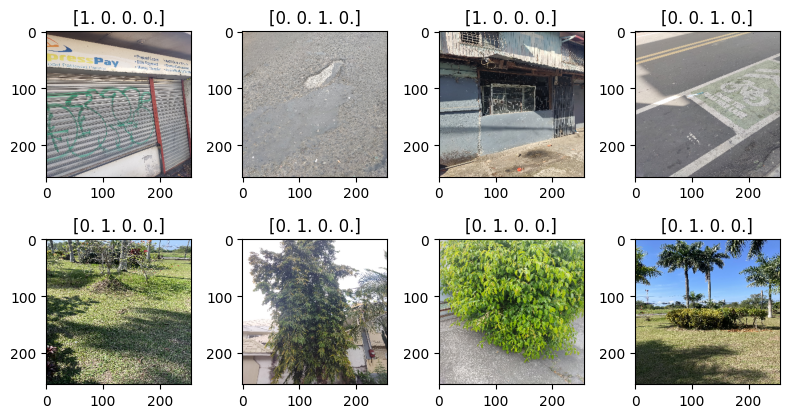

In [11]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(8,4.5))
for idx, ax_idx in enumerate(itertools.product(range(2),range(4))):
    ax[ax_idx].imshow(batch[0][idx].astype(float))
    ax[ax_idx].title.set_text(batch[1][idx])
    
fig.tight_layout()
plt.subplots_adjust(hspace=0.1)
plt.show()

In [19]:
total_batch_count = len(dataset) 
train_batch_count = total_batch_count // 4 * 3  # 75% of batches
test_batch_count = total_batch_count - train_batch_count
print(total_batch_count , train_batch_count, test_batch_count)

300 225 75


In [20]:
train_size, test_size = train_batch_count, test_batch_count
train_set = dataset.take(train_size)
test_set = dataset.skip(train_size).take(test_size)

In [22]:
train_set, val_set = tf.keras.utils.split_dataset(dataset=train_set, left_size=0.8, shuffle=True, seed=1)

## Make Model

In [28]:
model = Sequential()
model.add(RandomFlip(mode='horizontal', seed=1, input_shape=(256,256,3)))
model.add(RandomRotation(factor=0.2, seed=1))

model.add(Conv2D(input_shape=(256,256,3), filters=16, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())

model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())

model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dropout(0.2, seed=1))
model.add(Dense(units=128,activation="relu"))
model.add(Dense(units=128,activation="relu"))

model.add(Dense(units=4, activation="softmax"))


In [29]:
optimizer = tf.keras.optimizers.Adam(weight_decay=0.0002)

model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_2 (RandomR  (None, 256, 256, 3)       0         
 otation)                                                        
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 batch_normalization_6 (Bat  (None, 256, 256, 16)      64        
 chNormalization)                                                
                                                                 
 re_lu_6 (ReLU)              (None, 256, 256, 16)      0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 128, 128, 16)     

In [31]:
file_name = 'Model_V4-0-7_' + datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f'./logs/{file_name}'
checkpoint_filepath = f'./checkpoints/{file_name}'

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                             histogram_freq=1,
                                             profile_batch=2,
                                             write_graph=True,
                                             write_images=True,
                                             update_freq='epoch',
                                             embeddings_freq=1
                                            )
# es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
#                                                patience=6)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, 
                                                         monitor='val_accuracy', 
                                                         mode='auto', 
                                                         save_best_only=True, 
                                                         verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.3, 
                                                 patience=3, 
                                                 min_delta=0.001, 
                                                 mode='auto', 
                                                 verbose=1)

## Train and Inspect Model

In [32]:
hist = model.fit(train_set, 
                 validation_data=val_set, 
                 epochs=35,
                 verbose=1,
                 callbacks=[tb_callback, cp_callback]
                 # callbacks=[tb_callback, es_callback, cp_callback, reduce_lr]
                )
                 

Epoch 1/35
135/135 [==============================] - ETA: 0s - loss: 2.5153 - accuracy: 0.5926
Epoch 1: val_accuracy improved from -inf to 0.29779, saving model to ./checkpoints\Model_V4-0-7_20240304-132424
INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-7_20240304-132424\assets


INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-7_20240304-132424\assets


135/135 [==============================] - 40s 263ms/step - loss: 2.5153 - accuracy: 0.5926 - val_loss: 2.2962 - val_accuracy: 0.2978
Epoch 2/35
135/135 [==============================] - ETA: 0s - loss: 0.9914 - accuracy: 0.6519
Epoch 2: val_accuracy improved from 0.29779 to 0.45221, saving model to ./checkpoints\Model_V4-0-7_20240304-132424
INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-7_20240304-132424\assets


INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-7_20240304-132424\assets


135/135 [==============================] - 34s 254ms/step - loss: 0.9914 - accuracy: 0.6519 - val_loss: 1.4169 - val_accuracy: 0.4522
Epoch 3/35
135/135 [==============================] - ETA: 0s - loss: 0.6845 - accuracy: 0.7167
Epoch 3: val_accuracy improved from 0.45221 to 0.62868, saving model to ./checkpoints\Model_V4-0-7_20240304-132424
INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-7_20240304-132424\assets


INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-7_20240304-132424\assets


135/135 [==============================] - 34s 252ms/step - loss: 0.6845 - accuracy: 0.7167 - val_loss: 0.8438 - val_accuracy: 0.6287
Epoch 4/35
135/135 [==============================] - ETA: 0s - loss: 0.6325 - accuracy: 0.7398
Epoch 4: val_accuracy improved from 0.62868 to 0.74632, saving model to ./checkpoints\Model_V4-0-7_20240304-132424
INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-7_20240304-132424\assets


INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-7_20240304-132424\assets


135/135 [==============================] - 35s 263ms/step - loss: 0.6325 - accuracy: 0.7398 - val_loss: 0.7259 - val_accuracy: 0.7463
Epoch 5/35
135/135 [==============================] - ETA: 0s - loss: 0.6340 - accuracy: 0.7565
Epoch 5: val_accuracy did not improve from 0.74632
135/135 [==============================] - 31s 227ms/step - loss: 0.6340 - accuracy: 0.7565 - val_loss: 1.7211 - val_accuracy: 0.5257
Epoch 6/35
135/135 [==============================] - ETA: 0s - loss: 0.5374 - accuracy: 0.7759
Epoch 6: val_accuracy did not improve from 0.74632
135/135 [==============================] - 31s 230ms/step - loss: 0.5374 - accuracy: 0.7759 - val_loss: 1.1113 - val_accuracy: 0.7169
Epoch 7/35
135/135 [==============================] - ETA: 0s - loss: 0.5231 - accuracy: 0.8037
Epoch 7: val_accuracy did not improve from 0.74632
135/135 [==============================] - 29s 215ms/step - loss: 0.5231 - accuracy: 0.8037 - val_loss: 3.8555 - val_accuracy: 0.3934
Epoch 8/35
135/135 [===

INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-7_20240304-132424\assets


135/135 [==============================] - 34s 253ms/step - loss: 0.4035 - accuracy: 0.8546 - val_loss: 0.7994 - val_accuracy: 0.8309
Epoch 13/35
135/135 [==============================] - ETA: 0s - loss: 0.4418 - accuracy: 0.8306
Epoch 13: val_accuracy did not improve from 0.83088
135/135 [==============================] - 29s 217ms/step - loss: 0.4418 - accuracy: 0.8306 - val_loss: 0.4872 - val_accuracy: 0.8272
Epoch 14/35
135/135 [==============================] - ETA: 0s - loss: 0.3841 - accuracy: 0.8481
Epoch 14: val_accuracy did not improve from 0.83088
135/135 [==============================] - 29s 218ms/step - loss: 0.3841 - accuracy: 0.8481 - val_loss: 1.0884 - val_accuracy: 0.7206
Epoch 15/35
135/135 [==============================] - ETA: 0s - loss: 0.3952 - accuracy: 0.8528
Epoch 15: val_accuracy did not improve from 0.83088
135/135 [==============================] - 29s 216ms/step - loss: 0.3952 - accuracy: 0.8528 - val_loss: 0.9632 - val_accuracy: 0.8235
Epoch 16/35
135/1

INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-7_20240304-132424\assets


135/135 [==============================] - 34s 251ms/step - loss: 0.3253 - accuracy: 0.8713 - val_loss: 0.4951 - val_accuracy: 0.8493
Epoch 24/35
135/135 [==============================] - ETA: 0s - loss: 0.2980 - accuracy: 0.8806
Epoch 24: val_accuracy did not improve from 0.84926
135/135 [==============================] - 29s 217ms/step - loss: 0.2980 - accuracy: 0.8806 - val_loss: 0.8025 - val_accuracy: 0.8051
Epoch 25/35
135/135 [==============================] - ETA: 0s - loss: 0.2554 - accuracy: 0.9074
Epoch 25: val_accuracy did not improve from 0.84926
135/135 [==============================] - 36s 267ms/step - loss: 0.2554 - accuracy: 0.9074 - val_loss: 3.8770 - val_accuracy: 0.5368
Epoch 26/35
135/135 [==============================] - ETA: 0s - loss: 0.2946 - accuracy: 0.8954
Epoch 26: val_accuracy did not improve from 0.84926
135/135 [==============================] - 31s 231ms/step - loss: 0.2946 - accuracy: 0.8954 - val_loss: 7.2811 - val_accuracy: 0.3051
Epoch 27/35
135/1

INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-7_20240304-132424\assets


135/135 [==============================] - 40s 294ms/step - loss: 0.2689 - accuracy: 0.9056 - val_loss: 0.3123 - val_accuracy: 0.9044
Epoch 34/35
135/135 [==============================] - ETA: 0s - loss: 0.2076 - accuracy: 0.9259
Epoch 34: val_accuracy did not improve from 0.90441
135/135 [==============================] - 31s 228ms/step - loss: 0.2076 - accuracy: 0.9259 - val_loss: 1.2679 - val_accuracy: 0.6838
Epoch 35/35
135/135 [==============================] - ETA: 0s - loss: 0.2050 - accuracy: 0.9222
Epoch 35: val_accuracy did not improve from 0.90441
135/135 [==============================] - 30s 224ms/step - loss: 0.2050 - accuracy: 0.9222 - val_loss: 4.0425 - val_accuracy: 0.4559


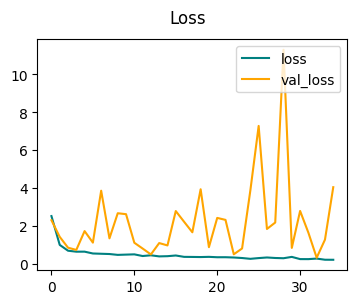

In [33]:
fig = plt.figure(figsize=(4,3))
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.suptitle('Loss')
plt.legend(loc='upper right')
plt.show()

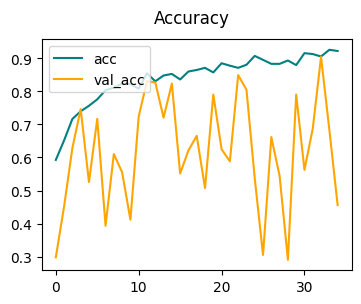

In [34]:
fig = plt.figure(figsize=(4,3))
plt.plot(hist.history['accuracy'], color='teal', label='acc')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_acc')
plt.suptitle('Accuracy')
plt.legend(loc='upper left')
plt.show()

### Evaluate Last Case of Model

In [35]:
f1 = F1Score()
pre = Precision()
rec = Recall()
c_acc = CategoricalAccuracy()

In [36]:
for batch in test_set.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    f1.update_state(y, yhat)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    c_acc.update_state(y, yhat)

1/1 [==============================] - 0s 94ms/step


In [37]:
def print_scores(f1, pre, rec, c_acc):
    f1_score = f1.result().numpy() * 100
    pre_score = pre.result().numpy() * 100
    rec_score = rec.result().numpy() * 100
    c_acc_score = c_acc.result().numpy() * 100
    print(f"Precision: {pre_score:.2f}")
    print(f"Recall: {rec_score:.2f}")
    print(f"Categorical Accuracy: {c_acc_score:.2f}")
    print("F1 Score: ", f1_score)

In [38]:
print_scores(f1, pre, rec, c_acc)

Precision: 46.10
Recall: 45.33
Categorical Accuracy: 45.83
F1 Score:  [33.15508  48.180244 61.187218 35.02304 ]


## More Visualization (Tensorboard)

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import datetime

In [ ]:
test_log = 'logs/test'
img_dir = "D:\\DATASETS\\Car-Plant-House-Road-Dataset\\Sample-Thesis-Dataset\\2.png"

file_writer = tf.summary.create_file_writer(test_log)
img = image_to_numpy.load_image_file(os.path.join(img_dir))
img = cv2.resize(img, (256, 256))
img = np.reshape(img, (-1, 256, 256, 3))

In [ ]:
# Using the file writer, log the reshaped image.
with file_writer.as_default():
  tf.summary.image("Training data", img, step=0)

In [ ]:
# AppData/Local/Temp/.tensorboard-info - delete folder if it cannot load
%tensorboard --logdir=logs/

## Load Best Model from Checkpoint and Evaluate

In [39]:
saved_model = tf.keras.models.load_model("checkpoints\\Model_V4-0-7_20240304-132424")

In [40]:
saved_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_2 (RandomR  (None, 256, 256, 3)       0         
 otation)                                                        
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 batch_normalization_6 (Bat  (None, 256, 256, 16)      64        
 chNormalization)                                                
                                                                 
 re_lu_6 (ReLU)              (None, 256, 256, 16)      0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 128, 128, 16)     

In [41]:
best_result = saved_model.evaluate(test_set, return_dict=True, verbose=2)
print(best_result)

75/75 - 4s - loss: 0.2543 - accuracy: 0.9150 - 4s/epoch - 55ms/step
{'loss': 0.2543421685695648, 'accuracy': 0.9150000214576721}


In [42]:
f1 = F1Score()
pre = Precision()
rec = Recall()
c_acc = CategoricalAccuracy()

In [43]:
test_images = []
test_labels = []
test_preds = [] 

In [44]:
for batch in test_set.as_numpy_iterator():
    X, y = batch
    yhat = saved_model.predict(X)
    f1.update_state(y, yhat)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    c_acc.update_state(y, yhat)
    
    for i in range(len(y)):
        test_images.append(X[i])
        test_labels.append(y[i])
        test_preds.append(yhat[i])

1/1 [==============================] - 0s 111ms/step


In [45]:
print_scores(f1, pre, rec, c_acc)

Precision: 93.29
Recall: 92.67
Categorical Accuracy: 92.83
F1 Score:  [87.04318  96.644295 97.70492  89.86487 ]


## Visualize Misclassified Images

In [46]:
test_images_c = np.array(test_images)

test_labels_c = [np.argmax(x) for x in test_labels]
test_labels_c = np.array(test_labels_c)

test_preds_c = [np.argmax(x) for x in test_preds]
test_preds_c = np.array(test_preds_c)

In [47]:
test_labels_c[:10]

array([3, 3, 3, 1, 3, 0, 2, 0, 2, 1], dtype=int64)

In [48]:
test_labels[:10]

[array([0., 0., 0., 1.], dtype=float32),
 array([0., 0., 0., 1.], dtype=float32),
 array([0., 0., 0., 1.], dtype=float32),
 array([0., 1., 0., 0.], dtype=float32),
 array([0., 0., 0., 1.], dtype=float32),
 array([1., 0., 0., 0.], dtype=float32),
 array([0., 0., 1., 0.], dtype=float32),
 array([1., 0., 0., 0.], dtype=float32),
 array([0., 0., 1., 0.], dtype=float32),
 array([0., 1., 0., 0.], dtype=float32)]

###  Plotting Confusion Matrix 

In [49]:
cm = sklearn.metrics.confusion_matrix(test_labels_c, test_preds_c)

Text(0.5, 1.0, 'Confusion Matrix')

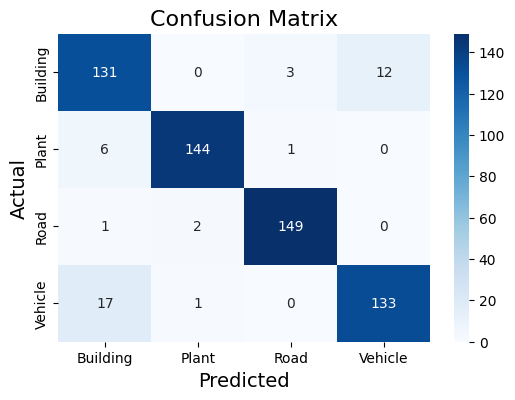

In [50]:
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(cm, annot=True, cmap="Blues", cbar=True,
            xticklabels=['Building', 'Plant', 'Road', 'Vehicle'],
            yticklabels=['Building', 'Plant', 'Road', 'Vehicle'],
            fmt='g'
           )
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

### Visualize Misclassified Images

In [51]:
misclassified = test_labels_c - test_preds_c

In [52]:
mis_idx = np.where(misclassified != 0)

In [53]:
m = np.squeeze(mis_idx)

In [54]:
def toClasses(x):
    if x == 0:
        return 'Building'
    if x == 1:
        return 'Plant'
    if x == 2:
        return 'Road'
    if x == 3:
        return 'Vehicle'

In [55]:
toClasses_vectorized = np.vectorize(toClasses)

In [56]:
test_label_names = toClasses_vectorized(test_labels_c)
test_pred_names = toClasses_vectorized(test_preds_c)

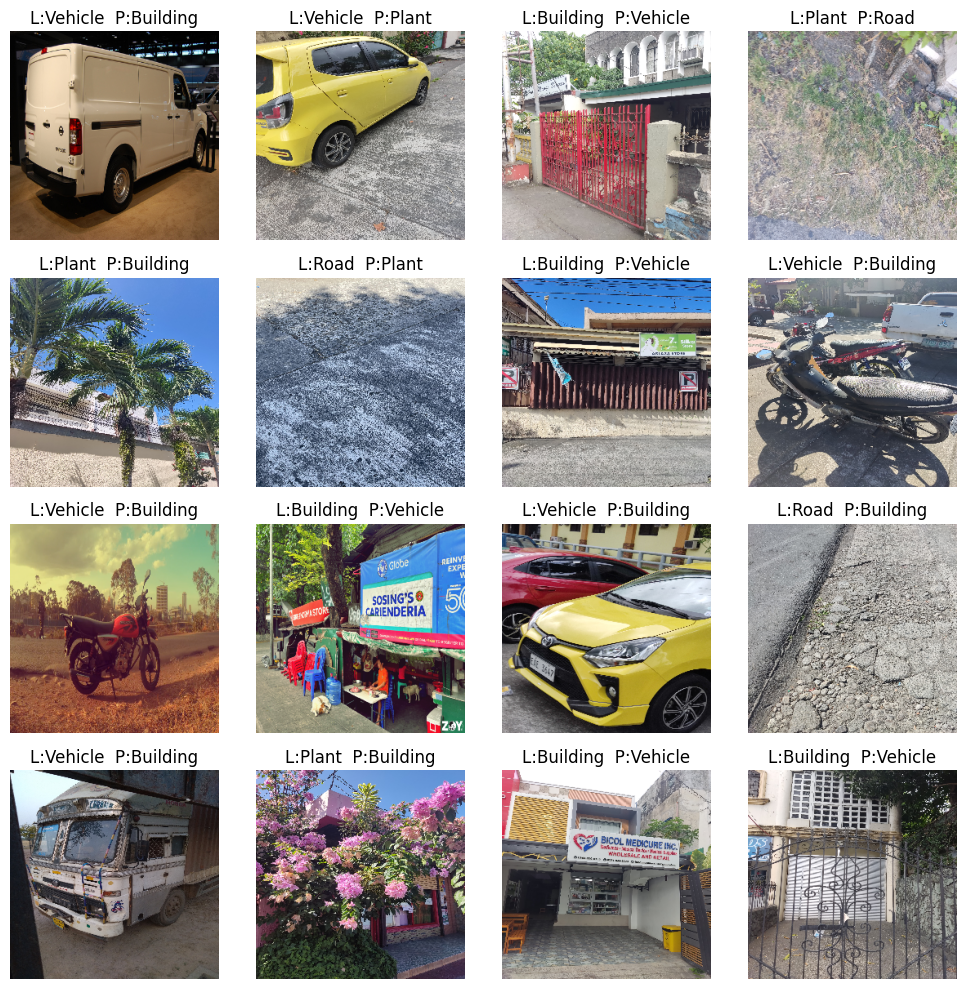

In [57]:
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for idx, ax_idx in enumerate(itertools.product(range(4), range(4))):
    ax[ax_idx].imshow(test_images_c[m[idx]].astype(float))
    ax[ax_idx].title.set_text(f'L:{test_label_names[m[idx]]}  P:{test_pred_names[m[idx]]}' )
    ax[ax_idx].axis('off')
fig.tight_layout()

## Save Model For API

In [ ]:
# saved_model = tf.keras.models.load_model('checkpoints\\Model_V4-0-0')

In [58]:
saved_model.save("models/Model_V4-0-7_20240304-132424.keras")

## See what the model sees

In [ ]:
saved_model.summary()

In [ ]:
len(saved_model.layers)

In [ ]:
layers_c1 = saved_model.layers[:6]
model_c1 = Sequential(layers_c1)
model_c1.summary()

In [ ]:
img_sample_dir = "D:\\DATASETS\\For-Thesis\\From Other Datasets\\Stanford-Car-Dataset\\cars_train\\cars_train\\00006.jpg"

In [ ]:
model_c1.input_shape

In [ ]:
image_size = 256
img_sample = image_to_numpy.load_image_file(os.path.join(img_sample_dir))
img_sample = cv2.resize(img_sample, (image_size, image_size))
img_sample = img_sample.astype(np.float32) / 255.0

In [ ]:
fig, ax = plt.subplots(figsize=(3,3))
ax.imshow(img_sample.astype(float))

In [ ]:
output_c1 = model_c1.predict(np.expand_dims(img_sample, 0))

In [ ]:
output_c1[0,:,:,0].shape

In [ ]:
def viz_grid(output, ncols=4, nrows=4):
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10,10))
    # itertools.product creates a permutation 
    for idx, ax_idx in enumerate(list(itertools.product(range(ncols), range(nrows)))):
        ax[ax_idx[1], ax_idx[0]].imshow(output[0,:,:,idx])

In [ ]:
viz_grid(output_c1, 4, 4)

In [ ]:
layers_c2 = saved_model.layers[:10]
model_c2 = Sequential(layers_c2)
model_c2.summary()

In [ ]:
output_c2 = model_c2.predict(np.expand_dims(img_sample, 0))

In [ ]:
viz_grid(output_c2, 4, 4)

In [ ]:
layers_c3 = saved_model.layers[:14]
model_c3 = Sequential(layers_c3)
model_c3.summary()

In [ ]:
output_c3 = model_c3.predict(np.expand_dims(img_sample, 0))
output_c3.shape

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=8, figsize=(15,15))
# itertools.product creates a permutation 
for idx, ax_idx in enumerate(list(itertools.product(range(4), range(8)))):
    ax[ax_idx[1], ax_idx[0]].imshow(output_c3[0,:,:,idx])
    
fig.tight_layout()

In [ ]:
yhat = saved_model.predict(np.expand_dims(img_sample, 0))

In [ ]:
# 0 is building
np.argmax(yhat)